# Tarefa 4
MO444A - Aprendizado de Máquina e Reconhecimento de Padrões

> Aplicação de métodos de aprendizado supervisionado para resolver problemas de classificação

__Alunos__:

- Leonardo Augusto Silva Bernardes - RA: 233548<br>

- Yan Prada - RA: 118982<br>

- Hismael - RA: 265684<br>

- André - RA: 230252<br>

Todos nós tivemos reuniões periodicamente para compartilhar ideias e sugestões de desenvolvimento do trabalho.

__Objetivo__:<br><br>
Um dos objetivos traçados no trabalho 4 foi desenvolver um modelo de classificação binária para classificação de comentários tóxicos. Estes comentários são oriundos da página de discussão do Wikipedia.

Foi consumido dois datasets um para treino e validação e um outro para testes.

Dataset de treino:
- Total de linhas: 159.571
- Comentários rotulados como <span style="color:red">tóxicos</span>: 15.294
- Comentários rotulados como <span style="color:green">não tóxicos</span>: 144.277

Dataset de testes:
- Total de linhas: 63.978
- Comentários rotulados como <span style="color:red">tóxicos</span>: 6.090
- Comentários rotulados como <span style="color:green">não tóxicos</span>: 57.888

In [1]:
#importando bibliotecas
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sn
import string
from nltk.stem import WordNetLemmatizer
import warnings
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hismaelcosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hismaelcosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## __Leitura dos dados__

In [2]:
df_sample_submission = pd.read_csv('sample_submission.csv')
df_train = pd.read_csv('train.csv')
df_test_labels = pd.read_csv('test_labels.csv')
df_test = pd.read_csv('test.csv')

#montando dataset de testes
df_merge_cols = pd.merge(df_test, df_test_labels, on='id')
df_sample_0 = df_merge_cols[df_merge_cols['toxic']==0]
df_sample_1 = df_merge_cols[df_merge_cols['toxic']==1]
df_test = pd.concat([df_sample_0,df_sample_1], ignore_index=True)

Função que gera uma nuvem de palavras para visualizar aquelas que são mais recorrentes entre os comentários

In [3]:
def plotar_worldcloud(dataset, title):

    # concatenar as palavras
    all_summary = " ".join(s for s in dataset['comment_text'])

    stop_words = set(stopwords.words('english'))

    # gerar uma wordcloud
    wordcloud = WordCloud(stopwords=stop_words,
                          background_color="white",
                          width=1600, height=800).generate(all_summary)


    # mostrar a imagem final
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()
    
    plt.title('Nuvem de palavras com comentários '+title+'.\n')
    plt.imshow(wordcloud);

## __Análise Exploratória__

In [4]:
df_train.shape

(159571, 8)

Pré visualização do dataset utilizado para treinamento dos modelos.

__comment_text__ (X): comentários do Wikipedia<br>
__toxic__ (y): coluna que indica se o comentário é tóxico ou não. (0 = não tóxico, 1 = tóxico)

In [5]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Através deste gráfico é possível perceber que há um grande desbalanceamento entre as classes e isto deve ser um ponto de atenção ao desenvolver os modelos.

In [6]:
df_train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

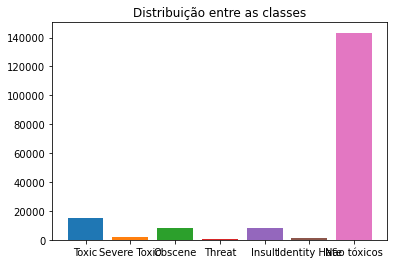

In [7]:
plt.bar('Toxic', len(df_train[df_train['toxic']==1]))
plt.bar('Severe Toxic', len(df_train[df_train['severe_toxic']==1]))
plt.bar('Obscene', len(df_train[df_train['obscene']==1]))
plt.bar('Threat', len(df_train[df_train['threat']==1]))
plt.bar('Insult', len(df_train[df_train['insult']==1]))
plt.bar('Identity Hate', len(df_train[df_train['identity_hate']==1]))

plt.bar('Não tóxicos', len(df_train[(df_train['toxic']==0) & (df_train['severe_toxic']==0) & (df_train['obscene']==0) &
                                    (df_train['threat']==0) & (df_train['insult']==0) & (df_train['identity_hate']==0)]))
plt.title('Distribuição entre as classes')
plt.show()

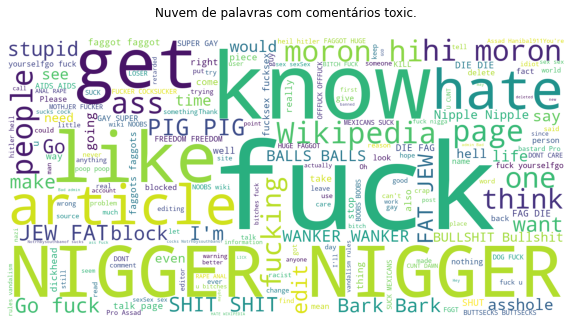

In [8]:
plotar_worldcloud(df_train[df_train['toxic']==1],'toxic')

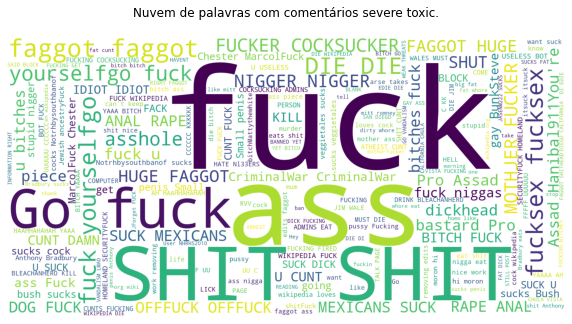

In [9]:
plotar_worldcloud(df_train[df_train['severe_toxic']==1],'severe toxic')

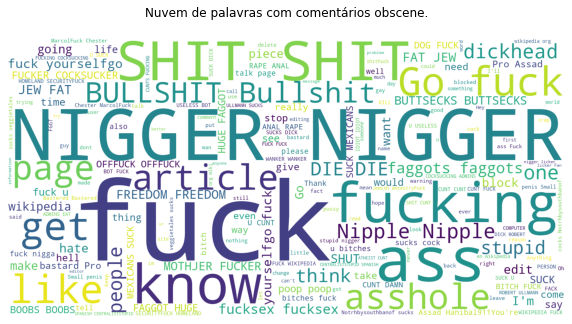

In [10]:
plotar_worldcloud(df_train[df_train['obscene']==1],'obscene')

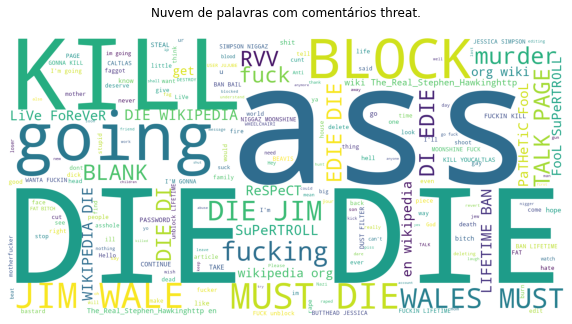

In [11]:
plotar_worldcloud(df_train[df_train['threat']==1],'threat')

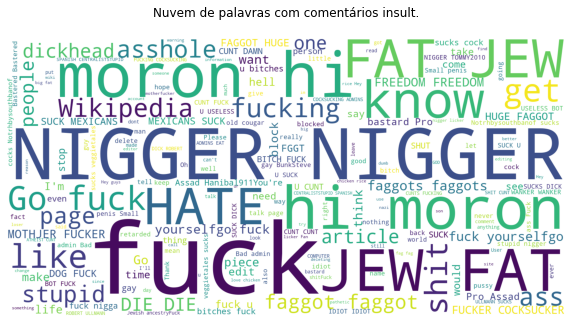

In [12]:
plotar_worldcloud(df_train[df_train['insult']==1],'insult')

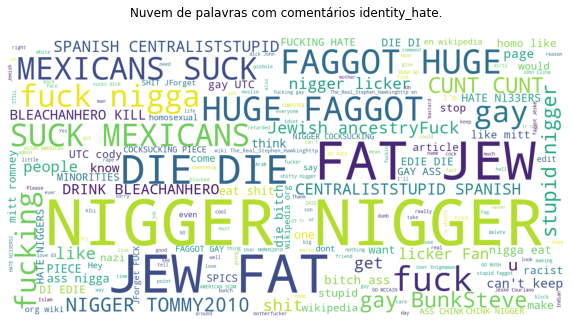

In [13]:
plotar_worldcloud(df_train[df_train['identity_hate']==1],'identity_hate')

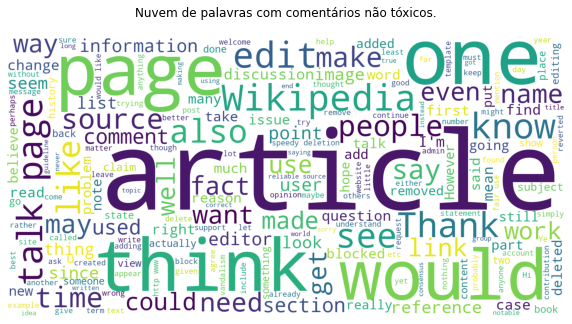

In [14]:
plotar_worldcloud(df_train[(df_train['toxic']==0) & (df_train['severe_toxic']==0) & (df_train['obscene']==0) &
                (df_train['threat']==0) & (df_train['insult']==0) & (df_train['identity_hate']==0)],'não tóxicos')

## __Pré Processamento__

Durante o desenvolvimento do trabalho foram testadas várias técnicas para tratar dados desbalanceados, aquela que apresentou uma melhor performance até o momento e com uma maior capacidade de generalização foi a __RandomOverSampler__ com __sampling_strategy__ igual a 0.65.

O RandomOverSampler seleciona um conjunto aleatório de cópias de exemplos de classes minoritárias e adiciona aos dados. Isso pode aumentar a probabilidade de overfitting. Além disso, pode diminuir o desempenho do classificador e aumentar o esforço computacional.

Mesmo com estes pontos prejudiciais o RandomOverSampler adicionando 65% dos dados na classe minoritária resultou em uma melhor performance comparado a outras técnicas e também comparado a nenhum tipo de tratamento para desbalancemento de classes.

Outras técnicas testadas foram:

- RandomOverSampler com sampling_strategy=0.5
- RandomOverSampler com sampling_strategy=0.7
- RandomOverSampler com sampling_strategy='minority'
- RandomUnderSampler com sampling_strategy='majority'
- Deleção de linhas da classe majoritária de forma aleatória para que houvesse total balanceamento

Obs: o __RandomUnderSampler__ realiza o mesmo trabalho do RandomOverSampler porém trabalhando com a classe majoritária

In [15]:
df_train['Toxic_comment'] = np.where(df_train[['toxic', 'severe_toxic', 'obscene', 'threat', 
                                               'insult', 'identity_hate']].sum(axis=1)>0, 1, 0)

In [16]:
X = df_train.iloc[:,0:2]
y = df_train['Toxic_comment']

#oversample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
oversample = RandomOverSampler(sampling_strategy=0.65)
X_over, y_over = oversample.fit_resample(X,y)

In [17]:
data_choosed = pd.merge(X_over, df_train, on='id', how='inner')
X_over = data_choosed[['id', 'comment_text_x']]
X_over.columns = ['id', 'comment_text']

y_over = data_choosed[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

Como todos os nossos dados são textos, o pré processamento é de suma importância para obter um bom resultado.

Abaixo a função tokenize remove as pontuações, caracteres especiais, realiza a lematização dos comentários com comprimento maior que 2.

Na lematização, reduzimos a palavra à forma de raiz de dicionário. Por exemplo, "gatos" é convertido em "gato". A lematização é feita para evitar a criação de recursos semanticamente semelhantes, mas sintaticamente diferentes. Por exemplo, não queremos dois recursos diferentes chamados "gatos" e "gato", que são semanticamente semelhantes, portanto, fazemos a lematização.

Após a comparação entre diferentes vetorizadores (TFIDFVectorizer e CountVectorizer), escolhemos TFIDFVectorizer, que nos fornece um melhor desempenho.

__TFIDFVectorizer__: consiste em 2 partes, TF (Term Frequency) multiplicado por IDF (Inverse Document Frequency). A intuição principal sendo algumas palavras que aparecem com frequência em 1 documento e com menos frequência em outros documentos podem ser consideradas como um insight extra para aquele documento e podem ajudar nosso modelo a aprender com essa informação adicional. Em suma, palavras comuns são penalizadas. Essas são frequências relativas identificadas como números de ponto flutuante.

In [18]:
def tokenize(text):
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

In [19]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X = vector.fit_transform(X_over['comment_text'])
X_final_test = vector.transform(df_test['comment_text'])

## __Modelagem multiclasse__

Para o problema de classificação com múltiplas classes, utilizamos a técnica One-vs-one, onde para cada classe de comentários criamos um modelo de aprendizado de máquina. Para auxiliar na comparação utilizamos dois tipos de algoritmos de aprendizado.

1. SVM
2. Regressão Logística

Para cada algoritmo fizemos uma busca gulosa pelos melhores parâmetros a sere utilizados. No SVM fizemos uma buca gulosa apenas no parâmetro *C*, enquanto na regressão logística buscamos sobre o *solver* e o *class_weight*.

## __Otimização de Parâmetros__

Para o fine-tuning selecionamos os dois modelos que obtiveram os melhores resulados no conjunto de validação.  

__Fine-tuning SVM__

Otimização dos parâmetros C e class_weight

... Processing obscene
Recall médio nos dados de treino: 0.9877980106306403
Recall médio nos dados de validação: 0.985735351491229
F1 médio nos dados de treino: 0.983771799573079
F1 médio nos dados de validação: 0.9722475865153705

Melhores parâmetros: {'C': 10}
Acurácia do melhor modelo: 0.977833793784912
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     37582
           1       0.96      0.99      0.97     24405

    accuracy                           0.98     61987
   macro avg       0.97      0.98      0.98     61987
weighted avg       0.98      0.98      0.98     61987

Teste do Modelo


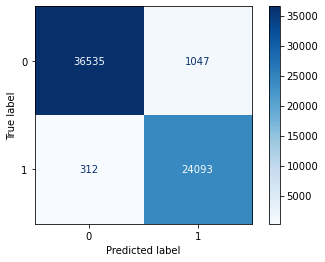

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     37582
           1       0.96      0.99      0.97     24405

    accuracy                           0.98     61987
   macro avg       0.97      0.98      0.98     61987
weighted avg       0.98      0.98      0.98     61987

Accurarcy: 0.9780760482036556
... Processing insult
Recall médio nos dados de treino: 0.980482880245862
Recall médio nos dados de validação: 0.9768758576008068
F1 médio nos dados de treino: 0.9699868743791626
F1 médio nos dados de validação: 0.9556353067387799

Melhores parâmetros: {'C': 5}
Acurácia do melhor modelo: 0.964327143766005
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     38299
           1       0.94      0.98      0.96     24845

    accuracy                           0.97     63144
   macro avg       0.96      0.97      0.96     63144
weighted avg       0.97      0.97      0.97     63144

Teste do 

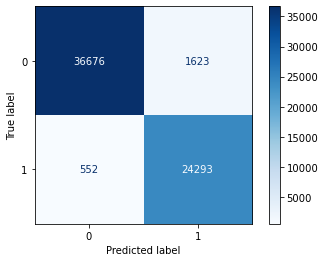

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     38299
           1       0.94      0.98      0.96     24845

    accuracy                           0.97     63144
   macro avg       0.96      0.97      0.96     63144
weighted avg       0.97      0.97      0.97     63144

Accurarcy: 0.9655549220828582
... Processing toxic
Recall médio nos dados de treino: 0.9800223431124928
Recall médio nos dados de validação: 0.9691729810245451
F1 médio nos dados de treino: 0.9766622937071505
F1 médio nos dados de validação: 0.9472692079347069

Melhores parâmetros: {'C': 5}
Acurácia do melhor modelo: 0.9577083757896883
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     29622
           1       0.93      0.97      0.95     19448

    accuracy                           0.96     49070
   macro avg       0.96      0.96      0.96     49070
weighted avg       0.96      0.96      0.96     49070

Teste do

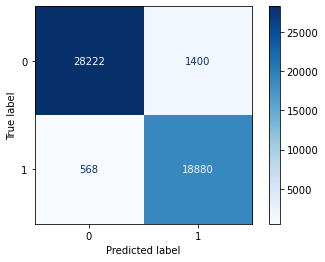

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     29622
           1       0.93      0.97      0.95     19448

    accuracy                           0.96     49070
   macro avg       0.96      0.96      0.96     49070
weighted avg       0.96      0.96      0.96     49070

Accurarcy: 0.9598940289382515
... Processing severe_toxic
Recall médio nos dados de treino: 0.9980444299683513
Recall médio nos dados de validação: 0.9979862567453385
F1 médio nos dados de treino: 0.9850415727852355
F1 médio nos dados de validação: 0.981528228639237

Melhores parâmetros: {'C': 10}
Acurácia do melhor modelo: 0.985311908695752
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     45452
           1       0.97      1.00      0.98     29558

    accuracy                           0.99     75010
   macro avg       0.98      0.99      0.98     75010
weighted avg       0.99      0.99      0.99     75010

Te

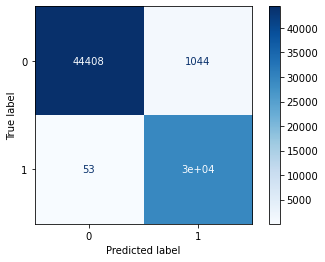

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     45452
           1       0.97      1.00      0.98     29558

    accuracy                           0.99     75010
   macro avg       0.98      0.99      0.98     75010
weighted avg       0.99      0.99      0.99     75010

Accurarcy: 0.9853752832955606
... Processing identity_hate
Recall médio nos dados de treino: 0.9973263996488957
Recall médio nos dados de validação: 0.9972242634392761
F1 médio nos dados de treino: 0.9934281293179748
F1 médio nos dados de validação: 0.989766113898163

Melhores parâmetros: {'C': 5}
Acurácia do melhor modelo: 0.9919811022196967
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     45638
           1       0.98      1.00      0.99     29716

    accuracy                           0.99     75354
   macro avg       0.99      0.99      0.99     75354
weighted avg       0.99      0.99      0.99     75354

T

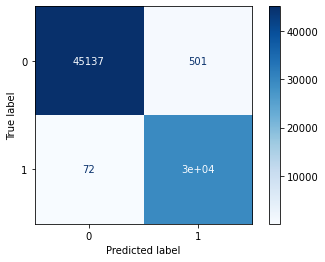

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     45638
           1       0.98      1.00      0.99     29716

    accuracy                           0.99     75354
   macro avg       0.99      0.99      0.99     75354
weighted avg       0.99      0.99      0.99     75354

Accurarcy: 0.9923958913926268
... Processing threat
Recall médio nos dados de treino: 1.0
Recall médio nos dados de validação: 1.0
F1 médio nos dados de treino: 0.9991667971701453
F1 médio nos dados de validação: 0.9985429391661986

Melhores parâmetros: {'C': 10}
Acurácia do melhor modelo: 0.9988854584805823
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46819
           1       1.00      1.00      1.00     30343

    accuracy                           1.00     77162
   macro avg       1.00      1.00      1.00     77162
weighted avg       1.00      1.00      1.00     77162

Teste do Modelo


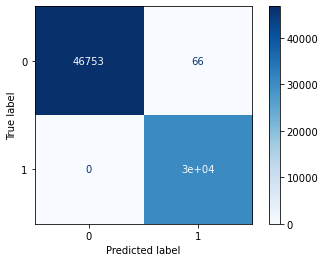

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46819
           1       1.00      1.00      1.00     30343

    accuracy                           1.00     77162
   macro avg       1.00      1.00      1.00     77162
weighted avg       1.00      1.00      1.00     77162

Accurarcy: 0.9991446566963013


In [20]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']
values_grid = {'C': [5, 10]}
preds_svm = []

for label in cols_target:
    print('... Processing {}'.format(label))
    X_temp = X
    y_temp = y_over[label]
    
    oversample = RandomOverSampler(sampling_strategy=0.65)
    X_label, y_label = oversample.fit_resample(X_temp,y_temp)
    X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.2, random_state=42)
    
    classifier = LinearSVC()
    
    grid_classifier = GridSearchCV(estimator=classifier, param_grid=values_grid, cv=5, 
                                   scoring=('accuracy','recall','f1'),
                                   return_train_score=True, refit='accuracy')
    grid_classifier.fit(X_train,y_train)

    best_classifier_svm = grid_classifier.best_estimator_

    preds_svm.append(best_classifier_svm)
    
    print('Recall médio nos dados de treino:', grid_classifier.cv_results_['mean_train_recall'].mean())
    print('Recall médio nos dados de validação:', grid_classifier.cv_results_['mean_test_recall'].mean())
    print('F1 médio nos dados de treino:', grid_classifier.cv_results_['mean_train_f1'].mean())
    print('F1 médio nos dados de validação:', grid_classifier.cv_results_['mean_test_f1'].mean())
    print('\nMelhores parâmetros:', grid_classifier.best_params_)
    print('Acurácia do melhor modelo:', grid_classifier.best_score_)
    
    predictions = best_classifier_svm.predict(X_test)
    print(classification_report(y_test,predictions))
    
    print('Teste do Modelo')
    plot_confusion_matrix(best_classifier_svm, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()

    print(classification_report(y_test,predictions))
    print('Accurarcy:',accuracy_score(y_test, predictions))

__Fine-tuning Logistic Regression__

Otimização dos parâmetros solver e class_weight

... Processing obscene
Recall médio nos dados de treino: 0.9589364384786095
Recall médio nos dados de validação: 0.9515827271607616
F1 médio nos dados de treino: 0.9544761297919734
F1 médio nos dados de validação: 0.9481846421762996

Melhores parâmetros: {'class_weight': 'balanced', 'solver': 'newton-cg'}
Acurácia do melhor modelo: 0.9611123434632681
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     37582
           1       0.94      0.97      0.96     24405

    accuracy                           0.96     61987
   macro avg       0.96      0.97      0.96     61987
weighted avg       0.97      0.96      0.97     61987

Teste do Modelo


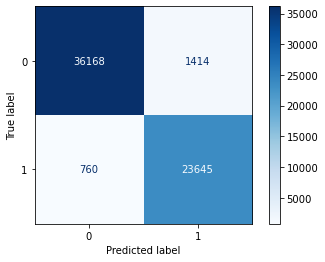

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     37582
           1       0.94      0.97      0.96     24405

    accuracy                           0.96     61987
   macro avg       0.96      0.97      0.96     61987
weighted avg       0.97      0.96      0.97     61987

Accurarcy: 0.9649281300917935
... Processing insult
Recall médio nos dados de treino: 0.9582240679045437
Recall médio nos dados de validação: 0.9507106926796082
F1 médio nos dados de treino: 0.9364110960082134
F1 médio nos dados de validação: 0.9290801377234824

Melhores parâmetros: {'class_weight': 'balanced', 'solver': 'lbfgs'}
Acurácia do melhor modelo: 0.9436994470279163
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     38299
           1       0.90      0.97      0.93     24845

    accuracy                           0.95     63144
   macro avg       0.94      0.95      0.94     63144
weighted avg       0.95

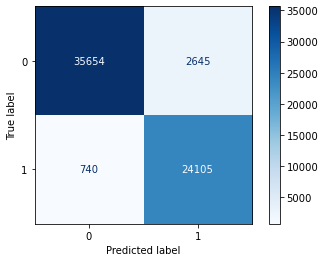

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     38299
           1       0.90      0.97      0.93     24845

    accuracy                           0.95     63144
   macro avg       0.94      0.95      0.94     63144
weighted avg       0.95      0.95      0.95     63144

Accurarcy: 0.9463923729887241
... Processing toxic
Recall médio nos dados de treino: 0.9320213500852709
Recall médio nos dados de validação: 0.9150292511279495
F1 médio nos dados de treino: 0.930393878782248
F1 médio nos dados de validação: 0.9158001623128151

Melhores parâmetros: {'class_weight': 'balanced', 'solver': 'lbfgs'}
Acurácia do melhor modelo: 0.9360454452822499
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     29622
           1       0.90      0.94      0.92     19448

    accuracy                           0.94     49070
   macro avg       0.93      0.94      0.93     49070
weighted avg       0.94  

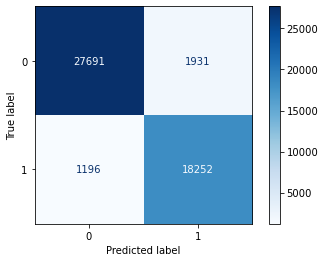

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     29622
           1       0.90      0.94      0.92     19448

    accuracy                           0.94     49070
   macro avg       0.93      0.94      0.93     49070
weighted avg       0.94      0.94      0.94     49070

Accurarcy: 0.9362747095985328
... Processing severe_toxic
Recall médio nos dados de treino: 0.9958269166375165
Recall médio nos dados de validação: 0.9957229198006935
F1 médio nos dados de treino: 0.968296054553658
F1 médio nos dados de validação: 0.9666751059550515

Melhores parâmetros: {'class_weight': None, 'solver': 'newton-cg'}
Acurácia do melhor modelo: 0.9747366166832595
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     45452
           1       0.95      0.99      0.97     29558

    accuracy                           0.98     75010
   macro avg       0.97      0.98      0.97     75010
weighted avg       0

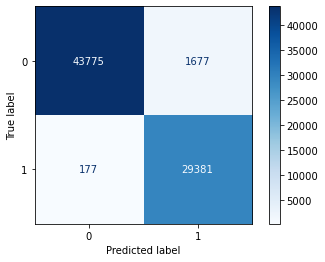

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     45452
           1       0.95      0.99      0.97     29558

    accuracy                           0.98     75010
   macro avg       0.97      0.98      0.97     75010
weighted avg       0.98      0.98      0.98     75010

Accurarcy: 0.9752832955605919
... Processing identity_hate
Recall médio nos dados de treino: 0.9958700829372026
Recall médio nos dados de validação: 0.9958174356401717
F1 médio nos dados de treino: 0.9794447205815292
F1 médio nos dados de validação: 0.9777536811052694

Melhores parâmetros: {'class_weight': None, 'solver': 'newton-cg'}
Acurácia do melhor modelo: 0.9838792612707217
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     45638
           1       0.97      1.00      0.98     29716

    accuracy                           0.99     75354
   macro avg       0.98      0.99      0.98     75354
weighted avg      

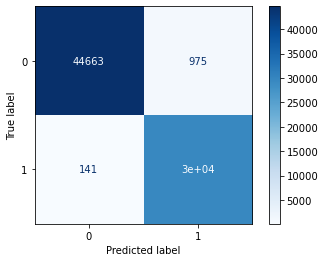

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     45638
           1       0.97      1.00      0.98     29716

    accuracy                           0.99     75354
   macro avg       0.98      0.99      0.98     75354
weighted avg       0.99      0.99      0.99     75354

Accurarcy: 0.9851899036547496
... Processing threat
Recall médio nos dados de treino: 1.0
Recall médio nos dados de validação: 1.0
F1 médio nos dados de treino: 0.9939216251402502
F1 médio nos dados de validação: 0.9932640362807432

Melhores parâmetros: {'class_weight': None, 'solver': 'newton-cg'}
Acurácia do melhor modelo: 0.9951983978128698
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     46819
           1       0.99      1.00      1.00     30343

    accuracy                           1.00     77162
   macro avg       1.00      1.00      1.00     77162
weighted avg       1.00      1.00      1.00     77162



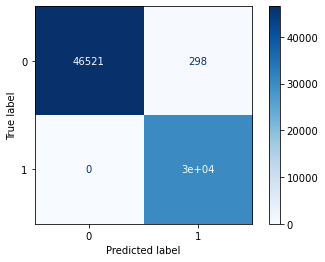

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     46819
           1       0.99      1.00      1.00     30343

    accuracy                           1.00     77162
   macro avg       1.00      1.00      1.00     77162
weighted avg       1.00      1.00      1.00     77162

Accurarcy: 0.9961379953863301


In [21]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']
values_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
               'class_weight': [None, 'balanced']}
preds_lr = []

for label in cols_target:
    print('... Processing {}'.format(label))
    X_temp = X
    y_temp = y_over[label]
    
    oversample = RandomOverSampler(sampling_strategy=0.65)
    X_label, y_label = oversample.fit_resample(X_temp,y_temp)

    X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.2, random_state=42)
    
    classifier = LogisticRegression()

    grid_classifier = GridSearchCV(estimator=classifier, param_grid=values_grid, cv=5, scoring=('accuracy','recall','f1'),
                                   return_train_score=True, refit='accuracy')
    grid_classifier.fit(X_train,y_train)

    best_classifier_lr = grid_classifier.best_estimator_

    preds_lr.append(best_classifier_lr)
    
    print('Recall médio nos dados de treino:', grid_classifier.cv_results_['mean_train_recall'].mean())
    print('Recall médio nos dados de validação:', grid_classifier.cv_results_['mean_test_recall'].mean())
    print('F1 médio nos dados de treino:', grid_classifier.cv_results_['mean_train_f1'].mean())
    print('F1 médio nos dados de validação:', grid_classifier.cv_results_['mean_test_f1'].mean())
    print('\nMelhores parâmetros:', grid_classifier.best_params_)
    print('Acurácia do melhor modelo:', grid_classifier.best_score_)
    
    predictions = best_classifier_lr.predict(X_test)
    print(classification_report(y_test,predictions))
    
    print('Teste do Modelo')
    plot_confusion_matrix(best_classifier_lr, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()

    print(classification_report(y_test,predictions))
    print('Accurarcy:',accuracy_score(y_test, predictions))

## __Comparando os resultados__

In [22]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

i = 0

acc_balanceada = []
precision = []
recall = []
f1_scr = []
auc_roc = []
precision_recall_auc = []

for label in cols_target:
    y_test = df_test[label]
    predictions_svm = preds_svm[i].predict(X_final_test)
    predictions_svm_probna = preds_svm[i].decision_function(X_final_test)
    
    acc_balanceada.append(balanced_accuracy_score(y_test, predictions_svm))
    precision.append(precision_score(y_test, predictions_svm, average='weighted'))
    recall.append(recall_score(y_test, predictions_svm, average='weighted'))
    f1_scr.append(f1_score(y_test, predictions_svm, average='weighted'))
    
    auc_roc.append(roc_auc_score(y_test, predictions_svm_probna))
    
    i+=1

In [23]:
svm_scores = pd.DataFrame()
svm_scores['Modelo'] = cols_target
svm_scores['Acurácia Balanceada'] = acc_balanceada
svm_scores['Precisão'] = precision
svm_scores['Recall'] = recall
svm_scores['F1-Score'] = f1_scr
svm_scores['Área da Curva ROC'] = auc_roc

svm_scores

,Modelo,Acurácia Balanceada,Precisão,Recall,F1-Score,Área da Curva ROC
0,obscene,0.811237,0.949394,0.935931,0.941378,0.912060
1,insult,0.768914,0.944498,0.927600,0.934673,0.891110
2,toxic,0.853223,0.928064,0.888337,0.901756,0.930019
3,severe_toxic,0.757422,0.992205,0.972834,0.981594,0.926851
4,identity_hate,0.717336,0.985356,0.977899,0.981240,0.926087
5,threat,0.687966,0.995578,0.994748,0.995138,0.944519


In [24]:
i=0
acc_balanceada = []
precision = []
recall = []
f1_scr = []
auc_roc = []
precision_recall_auc = []

for label in cols_target:
    y_test = df_test[label]
    predictions_lr = preds_lr[i].predict(X_final_test)
    predictions_lr_probna = preds_lr[i].decision_function(X_final_test)
    
    acc_balanceada.append(balanced_accuracy_score(y_test, predictions_lr))
    precision.append(precision_score(y_test, predictions_lr, average='weighted'))
    recall.append(recall_score(y_test, predictions_lr, average='weighted'))
    f1_scr.append(f1_score(y_test, predictions_lr, average='weighted'))
    
    auc_roc.append(roc_auc_score(y_test, predictions_lr_probna))
    
    i+=1

In [25]:
lr_scores = pd.DataFrame()
lr_scores['Modelo'] = cols_target
lr_scores['Acurácia Balanceada'] = acc_balanceada
lr_scores['Precisão'] = precision
lr_scores['Recall'] = recall
lr_scores['F1-Score'] = f1_scr
lr_scores['Área da Curva ROC'] = auc_roc

lr_scores

,Modelo,Acurácia Balanceada,Precisão,Recall,F1-Score,Área da Curva ROC
0,obscene,0.879768,0.960426,0.945012,0.950586,0.961774
1,insult,0.855232,0.956782,0.934665,0.942883,0.952644
2,toxic,0.888127,0.935217,0.877051,0.895046,0.954019
3,severe_toxic,0.853880,0.993677,0.978790,0.985181,0.976362
4,identity_hate,0.834792,0.988786,0.979493,0.983300,0.970406
5,threat,0.842529,0.996503,0.992122,0.993961,0.978979


Tanto o SVM quanto a Regressão Logística apresentaram bons resultados com a otimização de hiperparâmetros. Contudo, o SVM ainda sim obteve uma pequena performance acima da Regressão Logística conforme mostrado nos valores de Recall e Precisão.

__Conclusão__: após testar diversos modelos e técnicas diferentes este foi o resultado obtido até o momento.

Os resultados utilizando a modelagem multiclasse One-vs-one mostraram-se excelentes, tanto no processo de treinamento, validação e teste, com ambas as métricas mantendo-se próximas. Os rsultados do SVM para precisão e Recall, mostraram-se um pouco superiores que o da Regressão Logística, entretanto este por sua vez apresentou valores de curva ROC 5pp, na média, melhores que os modelos desenvolvidos com SVM.

Como próximos passos podemos avaliar os seguintes itens:

    1. Experimentar outras formas de vetorizar dados de texto
    2. Melhorar o pré-processamento
    3. Testar outros modelos e/ou modelos mais complexos (lightgbm, métodos de ensemble e boosting, redes neurais)